In [2]:

%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from mGST import additional_fns, algorithm, qiskit_interface
from qiskit.circuit.library import RXGate, RYGate, RZZGate, IGate

In [ ]:
# Example usage with RX, RY, and RZZ gates
rx_pi_2 = RXGate(np.pi / 2)
rx_pi = RXGate(np.pi)
ry_pi_2 = RYGate(np.pi / 2)
ry_pi = RYGate(np.pi)
rzz_pi_2 = RZZGate(np.pi / 2)
idle_gate = IGate()

# Convert to Kraus operators
kraus_rx_pi_2 = qiskit_interface.qiskit_gate_to_kraus(rx_pi_2)
kraus_rx_pi = qiskit_interface.qiskit_gate_to_kraus(rx_pi)
kraus_ry_pi_2 = qiskit_interface.qiskit_gate_to_kraus(ry_pi_2)
kraus_ry_pi = qiskit_interface.qiskit_gate_to_kraus(ry_pi)
kraus_rzz_pi_2 = qiskit_interface.qiskit_gate_to_kraus(rzz_pi_2)
kraus_idle = qiskit_interface.qiskit_gate_to_kraus(idle_gate)

print("Kraus operator for RX(pi/2):", kraus_rx_pi_2)
print("Kraus operator for RX(pi):", kraus_rx_pi)
print("Kraus operator for RY(pi/2):", kraus_ry_pi_2)
print("Kraus operator for RY(pi):", kraus_ry_pi)
print("Kraus operator for RZZ(pi/2):", kraus_rzz_pi_2)

In [4]:
kraus_operator_set = np.array([[kraus_idle], [kraus_rx_pi_2], [kraus_ry_pi_2], [kraus_rx_pi], [kraus_ry_pi]])
gate_set = [idle_gate, rx_pi_2, ry_pi_2, rx_pi, ry_pi]

pdim = 2   # physical dimension
r = pdim**2   # matrix dimension of the gate superoperators
sequence_length = 8  # maximum number of gates in each measurement sequence (sequence length)
gate_set_length = len(gate_set)  # number of gates in the gate set
rK_true = 1   # rank of simulated gates used for testing
rK = 1   # rank of the mGST model estimate
n_povm = 2   # number of POVM-elements
shots = 1000
sequence_number = 100

gate_sequence = qiskit_interface.get_gate_sequence(sequence_number, sequence_length, gate_set)

In [14]:
results = qiskit_interface.simulate_circuit(gate_sequence, gate_set, 1, shots)

Starting optimization...
 20%|██        | 6/30 [00:01<00:04,  4.87it/s]
Optimization successful, improving estimate over full data....
 40%|████      | 4/10 [00:01<00:02,  2.08it/s]
#################
	 Convergence criterion satisfied
	 Final objective function value 0.00011362654927502947 with # of initializations: 1 
 	 Total runtime: 3.1610500812530518


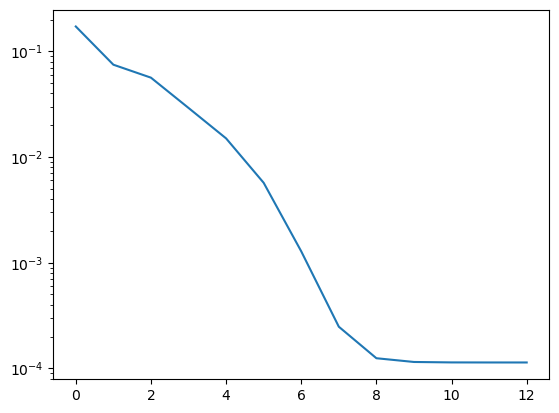

Mean variation error: 0.007892897925780884


In [23]:
X_true = np.einsum('ijkl,ijnm -> iknlm', kraus_operator_set, kraus_operator_set.conj()
                   ).reshape(gate_set_length, r, r)   # tensor of superoperators

K_depol = additional_fns.depol(pdim, 0.02)  # Kraus-rep of depolarizing channel
G_depol = np.einsum('jkl,jnm -> knlm', K_depol, K_depol.conj()).reshape(r, r)
# |10> initial state with depolarizing noise
rho_true = G_depol@np.array([[1, 0], [0, 0]]).reshape(-1).astype(np.complex128)

# Computational basis measurement:
E1 = np.array([[1, 0], [0, 0]]).reshape(-1)
E2 = np.array([[0, 0], [0, 1]]).reshape(-1)
E_true = np.array([E1, E2]).astype(np.complex128)   # Full POVM

# simulate finite sampling statistics
y_sampled = results.copy()

delta = .1  # unitary noise parameter

# Generate noisy version of true gate set
K0 = np.zeros((gate_set_length, rK, pdim, pdim)).astype(np.complex128)
for i in range(gate_set_length):
    U_p = expm(delta*1j*additional_fns.randHerm(pdim)
               ).astype(np.complex128)   # unitary noise
    K0[i] = np.einsum('jkl,lm', kraus_operator_set[i], U_p)
X0 = np.einsum('ijkl,ijnm -> iknlm', K0, K0.conj()).reshape(gate_set_length, r, r)

rho0 = additional_fns.randpsd(r).copy()   # random initial state
A0 = additional_fns.randKrausSet(1, r, n_povm)[0].conj()   # random POVM decomposition
E0 = np.array([(A0[i].T.conj()@A0[i]).reshape(-1)
              for i in range(n_povm)]).copy()

bsize = 50   # The batch size on which the optimization is started
K, X, E, rho, res_list = algorithm.run_mGST(y_sampled, gate_sequence, sequence_length, gate_set_length, r,
                                            rK, n_povm, bsize, shots, method='SFN',
                                            max_inits=10, max_iter=30, final_iter=10,
                                            target_rel_prec=1e-4, init=[K0, E0, rho0])
plt.semilogy(res_list)   # plot the objective function over the iterations
plt.show()
print('Mean variation error:', additional_fns.MVE(X_true, E_true, rho_true, X, E,
      rho, gate_set_length, sequence_length, n_povm)[0])   # output the final mean variation error

In [31]:
def kraus_to_pauli_rotation(kraus_op):
    """
    Decompose a single-qubit Kraus operator into Pauli matrices and find the rotation angles.

    Parameters:
    kraus_op (np.array): The Kraus operator (2x2 matrix).

    Returns:
    tuple: Rotation angles (theta, phi) around the Bloch sphere.
    """
    # Pauli matrices
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])

    # Coefficients for Pauli decomposition
    a_x = np.trace(np.dot(kraus_op, sigma_x)) / 2
    a_y = np.trace(np.dot(kraus_op, sigma_y)) / 2
    a_z = np.trace(np.dot(kraus_op, sigma_z)) / 2

    # Calculate rotation angles (theta and phi)
    theta = 2 * np.arccos(a_z)
    phi = np.arctan2(np.imag(a_y), np.imag(a_x))

    theta_pi = np.real(theta) / np.pi
    phi_pi = np.real(phi) / np.pi

    return theta_pi, phi_pi

In [34]:
kraus_operator_set

array([[[[ 1.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
         [ 0.00000000e+00+0.j        ,  1.00000000e+00+0.j        ]]],


       [[[ 7.07106781e-01+0.j        ,  0.00000000e+00-0.70710678j],
         [ 0.00000000e+00-0.70710678j,  7.07106781e-01+0.j        ]]],


       [[[ 7.07106781e-01+0.j        , -7.07106781e-01+0.j        ],
         [ 7.07106781e-01+0.j        ,  7.07106781e-01+0.j        ]]],


       [[[ 6.12323400e-17+0.j        ,  0.00000000e+00-1.j        ],
         [ 0.00000000e+00-1.j        ,  6.12323400e-17+0.j        ]]],


       [[[ 6.12323400e-17+0.j        , -1.00000000e+00+0.j        ],
         [ 1.00000000e+00+0.j        ,  6.12323400e-17+0.j        ]]]])

In [35]:
for i in range(5):
    theta, phi = kraus_to_pauli_rotation(kraus_operator_set[i][0])
    print("Theta:", theta, "Phi:", phi)

Theta: 1.0 Phi: 0.0
Theta: 1.0 Phi: 1.0
Theta: 1.0 Phi: -0.5
Theta: 1.0 Phi: 1.0
Theta: 1.0 Phi: -0.5


In [37]:
kraus_to_pauli_rotation([[1, 0], [0, 1]])

(1.0, 0.0)